# Makespan minimization with LP (COIN-OR)

In [1]:
import json
import pandas as pd

# Utils
import src.utils.visualization.gantt_diagram as gantt
from src.utils.analysis_basics import check_constraints as check

# Domain data
from src.domain.Query import RoutingQuery
from src.domain.Initializer import JobsInitializer
from src.domain.Collection import LiveJobCollection

# Solver
from src.solvers.LP_Solver import Solver

pd.set_option('display.min_rows', 16)
pd.set_option('display.max_rows', 29)

In [2]:
from configs.path_manager import get_path

# File paths
logs_path = get_path("data", "logs")

### I. Load routing

In [3]:
routings = RoutingQuery.get_by_source_name(source_name="Fisher and Thompson 10x10")

for routing in routings[:2]:
    print(routing)
    for operation in routing.operations:
        print(f" {operation}")

Routing(id='01-00', source_id=1)
 RoutingOperation(routing_id='01-00', position_number=0, machine_name='M01-00', duration=29)
 RoutingOperation(routing_id='01-00', position_number=1, machine_name='M01-01', duration=78)
 RoutingOperation(routing_id='01-00', position_number=2, machine_name='M01-02', duration=9)
 RoutingOperation(routing_id='01-00', position_number=3, machine_name='M01-03', duration=36)
 RoutingOperation(routing_id='01-00', position_number=4, machine_name='M01-04', duration=49)
 RoutingOperation(routing_id='01-00', position_number=5, machine_name='M01-05', duration=11)
 RoutingOperation(routing_id='01-00', position_number=6, machine_name='M01-06', duration=62)
 RoutingOperation(routing_id='01-00', position_number=7, machine_name='M01-07', duration=56)
 RoutingOperation(routing_id='01-00', position_number=8, machine_name='M01-08', duration=44)
 RoutingOperation(routing_id='01-00', position_number=9, machine_name='M01-09', duration=21)
Routing(id='01-01', source_id=1)
 Rout

### II. Create jobs routings (without any change)

In [4]:
jobs = JobsInitializer.create_simple_jobs(routings = routings, shuffle=False)
for job in jobs[:2]:
    print(job)
    for operation in job.operations:
        print(f" {operation}")


Job(id='01-0000', routing_id='01-00', arrival=None, earliest_start=0, deadline=None, sum_duration=395, max_bottleneck_utilization=None)
 JobOperation(job_id='01-0000', position_number=0, machine_name='M01-00', duration=29)
 JobOperation(job_id='01-0000', position_number=1, machine_name='M01-01', duration=78)
 JobOperation(job_id='01-0000', position_number=2, machine_name='M01-02', duration=9)
 JobOperation(job_id='01-0000', position_number=3, machine_name='M01-03', duration=36)
 JobOperation(job_id='01-0000', position_number=4, machine_name='M01-04', duration=49)
 JobOperation(job_id='01-0000', position_number=5, machine_name='M01-05', duration=11)
 JobOperation(job_id='01-0000', position_number=6, machine_name='M01-06', duration=62)
 JobOperation(job_id='01-0000', position_number=7, machine_name='M01-07', duration=56)
 JobOperation(job_id='01-0000', position_number=8, machine_name='M01-08', duration=44)
 JobOperation(job_id='01-0000', position_number=9, machine_name='M01-09', duration

In [5]:
jobs_collection = LiveJobCollection(jobs)
print(f"Total number of operations: {jobs_collection.count_operations()}")

Total number of operations: 100


## Scheduling

In [6]:
solver = Solver(
    jobs_collection = jobs_collection,
    var_cat="Integer"
)
solver.build_makespan_problem()

### A) HiGHS with PuLP
> high performance serial and parallel solver

In [12]:
log_file_path = logs_path / "makespan_highs.log"

solver.solve_problem(
    solver_type= "HiGHS",
    time_limit = 60*10,
    relative_gap_limit= 0.05,
    log_file= log_file_path
)

In [13]:
solver_log = solver.get_solver_info()
print(json.dumps(solver_log, indent=2))

{
  "status": "Optimal",
  "objective_value": 1081.0,
  "num_variables": 1001,
  "num_constraints": 1900,
  "runtime": 60.06
}


In [14]:
schedule_job_collection = solver.get_schedule()
df_schedule = schedule_job_collection.to_operations_dataframe()
df_schedule

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Ready Time,Deadline
0,01-0000,01-00,0,M01-00,209.0,29,238.0,0,None
1,01-0000,01-00,1,M01-01,281.0,78,359.0,0,None
2,01-0000,01-00,2,M01-02,359.0,9,368.0,0,None
3,01-0000,01-00,3,M01-03,399.0,36,435.0,0,None
4,01-0000,01-00,4,M01-04,488.0,49,537.0,0,None
5,01-0000,01-00,5,M01-05,638.0,11,649.0,0,None
6,01-0000,01-00,6,M01-06,676.0,62,738.0,0,None
7,01-0000,01-00,7,M01-07,783.0,56,839.0,0,None
...,...,...,...,...,...,...,...,...,...
92,01-0009,01-09,2,M01-02,129.0,61,190.0,0,None


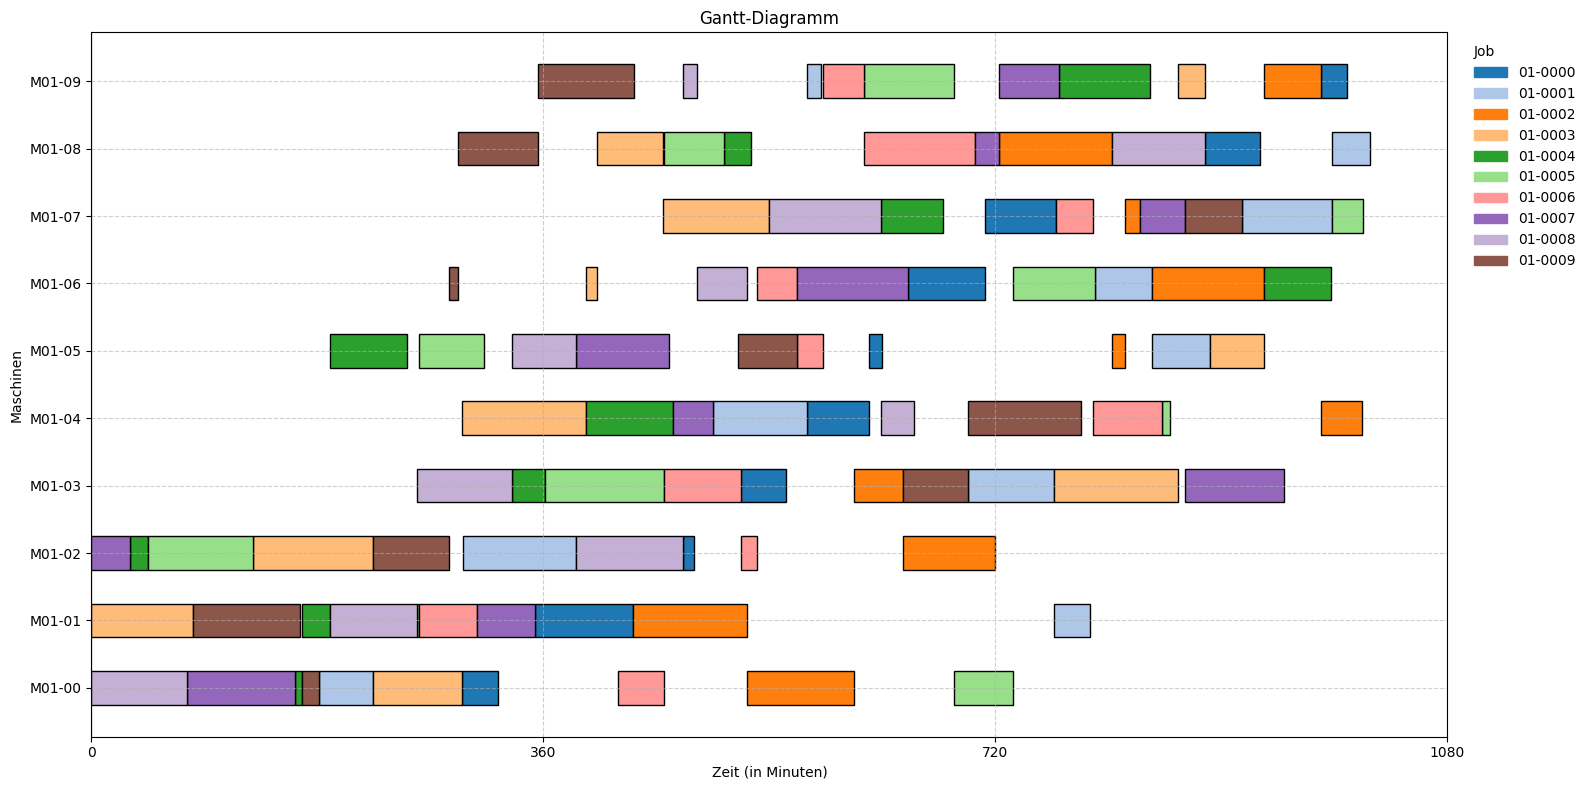

- Machine conflicts found: 8 rows affected.
        Job Routing_ID  Operation Machine  Start  Processing Time     End  \
91  01-0009      01-09          1  M01-00  168.0               13   181.0   
10  01-0001      01-01          0  M01-00  181.0               43   224.0   
62  01-0006      01-06          2  M01-03  456.0               61   517.0   
3   01-0000      01-00          3  M01-03  517.0               36   553.0   
78  01-0007      01-07          8  M01-07  835.0               36   871.0   
99  01-0009      01-09          9  M01-07  871.0               45   916.0   
18  01-0001      01-01          8  M01-07  916.0               72   988.0   
59  01-0005      01-05          9  M01-07  988.0               25  1013.0   

    Ready Time Deadline  
91           0     None  
10           0     None  
62           0     None  
3            0     None  
78           0     None  
99           0     None  
18           0     None  
59           0     None  
- 3 violation(s) of technolo

False

In [10]:
gantt.get_plot(df_schedule, perspective="Machine")
check.check_core_schedule_constraints(df_schedule)

In [11]:
check.is_duration_correct(df_schedule)

+ All durations match the difference between start and end.


True